In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.optimize import minimize
from scipy.interpolate import CubicSpline
import scipy.integrate as scpi

import cbmos
import cbmos.force_functions as ff
import cbmos.solvers.euler_forward as ef
import cbmos.solvers.euler_backward as eb
import cbmos.cell as cl

In /home/kubuntu1804/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/kubuntu1804/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/kubuntu1804/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/kubuntu1804/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/kubuntu1804/.local/lib/python3.6/site-packa

In [2]:
plt.style.use('seaborn-whitegrid')
plt.style.use('tableau-colorblind10')
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (6.75, 5),
          'lines.linewidth': 3.0,
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large',
          'legend.fontsize': 'xx-large',
         'font.size': 11,
          'font.family': 'serif',
          "mathtext.fontset": "dejavuserif",
         'axes.titlepad': 12,
        'axes.labelpad': 12}
plt.rcParams.update(params)

In [3]:
# calculate radius
def calculate_radius(cell_list):
    n_cells = len(cell_list)
    positions = np.array([cell.position for cell in cell_list])
    c = np.sum(positions, axis=0)/n_cells
    return 0.5 + max([np.linalg.norm(cell.position - c) for cell in cell_list])

In [4]:
# Simulation parameters
s = 1.0    # rest length
tf = 2.0  # final time
rA = 1.5   # maximum interaction distance
dim = 2
seed=67

params_cubic = {"mu": 5.70, "s": s, "rA": rA}
muR = 9.1
ratio = 0.21
params_poly = {'muA': muR*ratio, 'muR': muR, 'rA': rA, 'rR': 1.0/(1.0-np.sqrt(ratio)/3.0), 'n': 1.0, 'p': 1.0}
mu_gls = 1.95
params_gls = {'mu': mu_gls, 'a': 7.51}
params = {'cubic': params_cubic, 'pw. quad.': params_poly, 'GLS': params_gls}

In [5]:
force_names = ['cubic', 'pw. quad.', 'GLS']
solver_names = ['EF', 'EB']

defcolors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = {'cubic': defcolors[0], 'pw. quad.': defcolors[5], 'GLS': defcolors[6]}
linestyles = {'cubic': '-', 'pw. quad.': '--', 'GLS': '-.'}

In [6]:
models_ef = {'pw. quad.': cbmos.CBMModel(ff.PiecewisePolynomial(), ef.solve_ivp, dim), 
             'cubic': cbmos.CBMModel(ff.Cubic(), ef.solve_ivp, dim),
             'GLS': cbmos.CBMModel(ff.Gls(), ef.solve_ivp, dim)}
models_eb = {'pw. quad.': cbmos.CBMModel(ff.PiecewisePolynomial(), eb.solve_ivp, dim), 
             'cubic': cbmos.CBMModel(ff.Cubic(), eb.solve_ivp, dim),
             'GLS': cbmos.CBMModel(ff.Gls(), eb.solve_ivp, dim)}
model_dicts = {'EF': models_ef, 'EB': models_eb}

In [7]:
# Initial condition

# 2D honeycomb mesh
n_x = 5
n_y = 5
xcrds = [(2 * i + (j % 2)) * 0.5 for j in range(n_y) for i in range(n_x)]
ycrds = [np.sqrt(3) * j * 0.5 for j in range(n_y) for i in range(n_x)]

# make cell_list for the sheet
sheet = [cl.Cell(i, [x,y], -6.0, True, lambda t: 6 + t) for i, x, y in zip(range(n_x*n_y), xcrds, ycrds)]
# delete cells to make it circular
del sheet[24]
del sheet[20]
del sheet[19]
del sheet[9]
del sheet[4]
del sheet[0]

In [8]:
#prepare consistent initial data
solver_scipy = cbmos.CBMModel(ff.PiecewisePolynomial(), scpi.solve_ivp, dim)
t_data_init = [0, 0.0001]
(t_data, initial_sheet) = solver_scipy.simulate(sheet, t_data_init, {'muA': 0.21*9.1, 'muR': 9.1, 'rA': rA, 'rR': 1.0/(1.0-np.sqrt(0.21)/3.0), 'n': 1.0, 'p': 1.0}, {}, seed=seed)
initial_sheet = initial_sheet[-1]

In [9]:
dt = 5*1e-4
t_data_ref = np.arange(0, tf, dt)
#t_data_ref = np.linspace(0, tf, 10000+1)

#t_data_ref=[0,tf]
ref_sol_dicts = {}
for solver in solver_names:
    print(solver)
    models = model_dicts[solver]
    ref_sols = {}
    for force in force_names: 
        print(force)
        #params_solver = {'EF':{'dt': 0.0001}, 'EB': {'dt': 0.0001, 'jacobian': models[force].jacobian}}
        params_solver = {'EF':{'dt': dt}, 'EB': {'dt': dt}}
        (t_data, history) = models[force].simulate(initial_sheet, t_data_ref, params[force], params_solver[solver], seed=seed)
        ref_sols[force] = (t_data, {cell.ID: np.array([cell_list[i].position for cell_list in history])
                                    for i, cell in enumerate(history[0])})
    ref_sol_dicts[solver] = ref_sols
print('Done')

EF
cubic
pw. quad.
GLS
EB
cubic
pw. quad.
GLS
Done


In [10]:
dt_values = [0.001*1.25**n for n in range(0, 28)]

In [11]:
sol_dicts = {}

In [21]:
n = 1 
sol = {'cubic': [], 'pw. quad.': [], 'GLS': []}
for dt in dt_values:
    N = int(tf/dt) + 1
    print([ N, dt])
    #t_data = np.linspace(0,1,N)
    t_data = np.arange(0,tf,dt)
    
    for force in force_names:
        av_time = 0
        for j in np.arange(n):
            start = time.time()
            (t, history) = model_dicts['EF'][force].simulate(initial_sheet, t_data, params[force], {'dt': dt}, seed=seed)
            exec_time = time.time() - start
            av_time = av_time + exec_time
        av_time = av_time / n
        traj = {
            cell.ID: np.array([cell_list[i].position for cell_list in history])
            for i, cell in enumerate(history[0])
        }
        errorx = 0
        errory = 0
        t_ref = ref_sol_dicts['EF'][force][0]
        
        for ID, tr in traj.items():
            interx = np.interp(t_ref, t, tr[:, 0])
            intery = np.interp(t_ref, t, tr[:, 1])
            ref = ref_sol_dicts['EF'][force][1][ID]
            refx = ref[:,0]
            refy = ref[:,1]
            errorx = errorx + np.linalg.norm(interx-refx)/np.linalg.norm(refx)
            errory = errory + np.linalg.norm(intery-refy)/np.linalg.norm(refy)
        error = (errorx+errory)/len(history[0])
        sol[force].append((error, av_time))
sol_dicts['EF'] = sol

[2001, 0.001]
[1601, 0.00125]
[1281, 0.0015625]
[1025, 0.001953125]
[820, 0.00244140625]
[656, 0.0030517578125]
[525, 0.003814697265625]
[420, 0.00476837158203125]
[336, 0.0059604644775390625]
[269, 0.007450580596923828]
[215, 0.009313225746154785]
[172, 0.011641532182693481]
[138, 0.014551915228366852]
[110, 0.018189894035458565]
[88, 0.022737367544323206]
[71, 0.028421709430404007]
[57, 0.03552713678800501]
[46, 0.04440892098500626]
[37, 0.05551115123125783]
[29, 0.06938893903907228]
[24, 0.08673617379884035]
[19, 0.10842021724855044]
[15, 0.13552527156068805]
[12, 0.16940658945086007]
[10, 0.21175823681357508]
[8, 0.2646977960169689]
[7, 0.3308722450212111]
[5, 0.41359030627651383]


In [17]:
np.array(sol_dicts['EF']['cubic'])[:,0]

array([7.99261521e-04, 1.02265776e-03, 1.30278325e-03, 1.65433469e-03,
       2.09599250e-03, 2.65161015e-03, 3.35188401e-03, 4.23657361e-03,
       5.35792491e-03, 6.78565030e-03, 8.61478698e-03, 1.09794752e-02,
       1.40780857e-02, 1.82205917e-02, 2.39282671e-02, 3.21363692e-02,
       4.46048775e-02, 6.47795810e-02, 9.98753954e-02, 1.67958632e-01,
       3.35418977e-01, 6.50456170e-01, 9.61892139e-01, 1.34378379e+00,
       1.80764716e+00, 2.36479481e+00, 3.02376737e+00, 3.78548991e+00])

In [18]:
for force in force_names:
    print([force, dt_values[np.nonzero(np.array(sol_dicts['EF'][force])[:, 0] > 0.01)[0][0]]])

['cubic', 0.011641532182693481]
['pw. quad.', 0.014551915228366852]
['GLS', 0.018189894035458565]


In [19]:
for force in force_names:
    print([force, dt_values[np.nonzero(np.array(sol_dicts['EF'][force])[:, 0] > 0.1)[0][0]]])

['cubic', 0.06938893903907228]
['pw. quad.', 0.08673617379884035]
['GLS', 0.13552527156068805]


In [22]:
n = 1
sol = {'cubic': [], 'pw. quad.': [], 'GLS': []}
for dt in dt_values:
    N = int(tf/dt) + 1
    print([ N, dt])
    #t_data = np.linspace(0,1,N)
    t_data = np.arange(0,tf,dt)
    
    for force in force_names:
        av_time = 0
        for j in np.arange(n):
            start = time.time()
            (t, history) = model_dicts['EB'][force].simulate(initial_sheet, t_data, params[force], {'dt': dt}, seed=seed)
            exec_time = time.time() - start
            av_time = av_time + exec_time
        av_time = av_time / n
        traj = {
            cell.ID: np.array([cell_list[i].position for cell_list in history])
            for i, cell in enumerate(history[0])
        }
        errorx = 0
        errory = 0
        t_ref = ref_sol_dicts['EB'][force][0]
        
        for ID, tr in traj.items():
            interx = np.interp(t_ref, t, tr[:, 0])
            intery = np.interp(t_ref, t, tr[:, 1])
            ref = ref_sol_dicts['EB'][force][1][ID]
            refx = ref[:,0]
            refy = ref[:,1]
            errorx = errorx + np.linalg.norm(interx-refx)/np.linalg.norm(refx)
            errory = errory + np.linalg.norm(intery-refy)/np.linalg.norm(refy)
        error = (errorx+errory)/len(history[0])
        sol[force].append((error, av_time))
sol_dicts['EB'] = sol

[2001, 0.001]
[1601, 0.00125]
[1281, 0.0015625]
[1025, 0.001953125]
[820, 0.00244140625]
[656, 0.0030517578125]
[525, 0.003814697265625]
[420, 0.00476837158203125]
[336, 0.0059604644775390625]
[269, 0.007450580596923828]
[215, 0.009313225746154785]
[172, 0.011641532182693481]
[138, 0.014551915228366852]
[110, 0.018189894035458565]
[88, 0.022737367544323206]
[71, 0.028421709430404007]
[57, 0.03552713678800501]
[46, 0.04440892098500626]
[37, 0.05551115123125783]
[29, 0.06938893903907228]
[24, 0.08673617379884035]
[19, 0.10842021724855044]
[15, 0.13552527156068805]
[12, 0.16940658945086007]
[10, 0.21175823681357508]
[8, 0.2646977960169689]
[7, 0.3308722450212111]
[5, 0.41359030627651383]


In [22]:
for force in force_names:
    print([force, dt_values[np.nonzero(np.array(sol_dicts['EB'][force])[:, 0] > 0.01)[0][0]]])

['cubic', 0.014551915228366852]
['pw. quad.', 0.018189894035458565]
['GLS', 0.018189894035458565]


In [23]:
for force in force_names:
    print([force, dt_values[np.nonzero(np.array(sol_dicts['EB'][force])[:, 0] > 0.1)[0][0]]])

['cubic', 0.16940658945086007]
['pw. quad.', 0.21175823681357508]
['GLS', 0.2646977960169689]


In [24]:
dt_values

[0.001,
 0.00125,
 0.0015625,
 0.001953125,
 0.00244140625,
 0.0030517578125,
 0.003814697265625,
 0.00476837158203125,
 0.0059604644775390625,
 0.007450580596923828,
 0.009313225746154785,
 0.011641532182693481,
 0.014551915228366852,
 0.018189894035458565,
 0.022737367544323206,
 0.028421709430404007,
 0.03552713678800501,
 0.04440892098500626,
 0.05551115123125783,
 0.06938893903907228,
 0.08673617379884035,
 0.10842021724855044,
 0.13552527156068805,
 0.16940658945086007,
 0.21175823681357508,
 0.2646977960169689,
 0.3308722450212111,
 0.41359030627651383]

In [20]:
sol_dicts['EF']['GLS']

[(array([9.89849884e-05, 1.27282229e-04]), 1.1998612880706787),
 (array([0.00013666, 0.0001888 ]), 1.2749104499816895),
 (array([0.00021262, 0.00026843]), 0.41663503646850586),
 (array([0.00030826, 0.00037616]), 0.3345835208892822),
 (array([0.00036826, 0.0004795 ]), 0.38834285736083984),
 (array([0.00051065, 0.00063355]), 0.21513652801513672),
 (array([0.00068338, 0.00082677]), 0.17670297622680664),
 (array([0.00080291, 0.00102495]), 0.13388657569885254),
 (array([0.00110822, 0.0013586 ]), 0.1551206111907959),
 (array([0.00146367, 0.00174119]), 0.1787576675415039),
 (array([0.00204786, 0.00231749]), 0.1148538589477539),
 (array([0.00260492, 0.0029379 ]), 0.12369322776794434),
 (array([0.00319107, 0.00363181]), 0.04380917549133301),
 (array([0.00383194, 0.00459311]), 0.08020401000976562),
 (array([0.00492089, 0.00571476]), 0.028379201889038086),
 (array([0.00660423, 0.00740235]), 0.06640338897705078),
 (array([0.00836534, 0.00924735]), 0.018930673599243164),
 (array([0.01094523, 0.0118

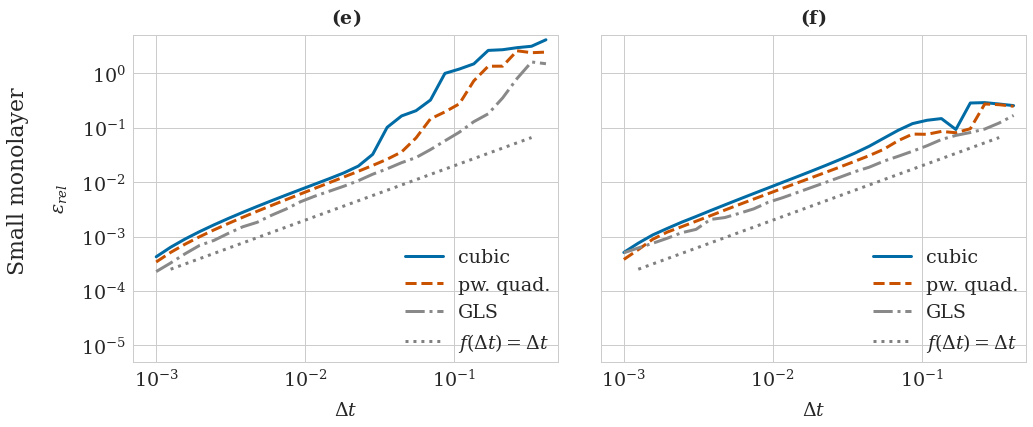

In [37]:

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 6), sharey=True, gridspec_kw={'wspace': 0.1})

# ax1
for force in force_names: 
    ax1.loglog(dt_values, np.array(sol_dicts['EF'][force])[:,0], label=force, color=colors[force], linestyle=linestyles[force])
    #plt.loglog(dt_values, np.array(sol_dicts['EF'][force])[:,1], label=force+' y')
ax1.loglog(dt_values[1:-1], np.array(dt_values[1:-1])*0.2, ':', label='$f(\Delta t)= \Delta t$', color='grey')
ax1.legend(loc='lower right', borderaxespad=0.)
#plt.legend()
ax1.set(xlabel='$\Delta t$')
ax1.set_title(r'$\bf{(e)}$')
ax1.set(ylabel='$\epsilon_{rel}$')
ax1.set_xlim([7*1e-4, 5*1e-1])
ax1.set_ylim([5*1e-6, 5*1e-0])
#ax1.set_xticklabels([])
#ax1.set_ylim([5*1e-8, 5*1e-0])
#ax1.text(0.0025, 25, 'Forward Euler method', fontsize=22)
ax1.text(0.0001, 0.00025, 'Small monolayer', fontsize=22, rotation='vertical')


#ax2
for force in force_names: 
    ax2.loglog(dt_values, np.array(sol_dicts['EB'][force])[:,0], label=force, color=colors[force], linestyle=linestyles[force])
    #plt.loglog(dt_values, np.array(sol_dicts[current_solver][force])[:,1], label=force+' y')
ax2.loglog(dt_values[1:-1], np.array(dt_values[1:-1])*0.2, ':', label='$f(\Delta t)= \Delta t$', color='grey')
ax2.legend(loc='lower right',borderaxespad=0.)
ax2.set(xlabel='$\Delta t$')
ax2.set_xlim([7*1e-4, 5*1e-1])
ax2.set_title(r'$\bf{(f)}$')
#ax2.set_xticklabels([])

#ax2.text(0.0025, 25, 'Backward Euler method', fontsize=22)
plt.savefig('convergence_study_EB_small_monolayer.pdf', bbox_inches='tight')

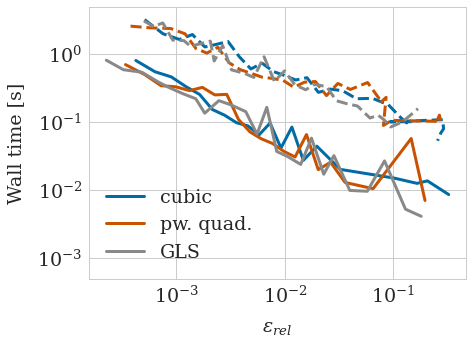

In [34]:
end_index = {'cubic': -8, 'pw. quad.': -7, 'GLS': -4}

for force in force_names:
    plt.loglog(np.array(sol_dicts['EF'][force])[:end_index[force],0], np.array(sol_dicts['EF'][force])[:end_index[force],1], label=force, color=colors[force])
    plt.loglog(np.array(sol_dicts['EB'][force])[:,0], np.array(sol_dicts['EB'][force])[:,1], linestyle='--', color=colors[force])

plt.xlabel('$\epsilon_{rel}$')    
plt.ylabel('Wall time [s]')
plt.ylim([5*1e-4, 5*1e-0])
plt.legend()
plt.savefig('exec_time_EB_small_monolayer.pdf', bbox_inches='tight')